In [15]:

import torch.nn as nn
import torchvision.models as models
from torchvision.models import EfficientNet_B2_Weights


class EmptyModule(nn.Module):
    def __init__(self):
        super(EmptyModule, self).__init__()

    def forward(self, x):
        return x


class EfficientNetGrayWithoutClassifier(nn.Module):
    def __init__(self):
        super(EfficientNetGrayWithoutClassifier, self).__init__()
        self.base_model = models.efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
        self.base_model.classifier = EmptyModule()
        self.base_model.eval()

    def forward(self, single_channel_input):
        rgb_input = torch.cat([single_channel_input] * 3, dim=1)
        return self.base_model(rgb_input.float())


model = EfficientNetGrayWithoutClassifier()

In [16]:
model.eval()

EfficientNetGrayWithoutClassifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tru

In [13]:
import torch

data = torch.load("preprocessed_images_with_metadata_and_target_small.pt.nosync")
train_record = data[0]
[target, age, implant], image = train_record
train_record

(tensor([ 1., 79.,  0.], dtype=torch.float64),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5882, 0.5529, 0.5294,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        dtype=torch.float64))

In [18]:
with torch.no_grad():
    features = model(image.float().unsqueeze(0).unsqueeze(0))
features.shape

torch.Size([1, 1408])

In [94]:
# Define an autoencoder class
class EfficientNetAutoencoder(nn.Module):
    def __init__(self, encoder):
        super(EfficientNetAutoencoder, self).__init__()

        # Encoder (EfficientNet)
        self.encoder = encoder

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(88, 64, kernel_size=4, stride=2, padding=1),  # EfficientNet-B2 specific adjustment
            nn.BatchNorm2d(64, momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16, momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4, momentum=0.01),
            nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1, momentum=0.01),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 88, 4, 4)
        x = self.decoder(x)
        return x


encoder = EfficientNetGrayWithoutClassifier()
ae = EfficientNetAutoencoder(encoder)

In [95]:
with torch.no_grad():
    restored_image = ae(image.float().unsqueeze(0).unsqueeze(0))
restored_image.shape

torch.Size([1, 1, 512, 512])

In [96]:
x_data = torch.load("preprocessed_images_with_metadata_and_target_small.pt.nosync")

In [97]:
import numpy as np

images = torch.tensor(np.asarray([d[1] for d in x_data]).reshape((-1, 1, 512, 512)))
images.shape

torch.Size([50, 1, 512, 512])

In [98]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X1_train, X1_val = train_test_split(images, test_size=0.15, random_state=3451)

train_dataset = TensorDataset(X1_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X1_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [99]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(ae.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ae.train()
    running_train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        batched_images, *_ = data  # Assuming you're using unlabeled data

        optimizer.zero_grad()

        outputs = ae(batched_images)
        loss = criterion(outputs.float(), batched_images.float())  # Compute reconstruction loss

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / (i + 1)
    train_losses.append(train_loss)

    ae.eval()  # Set the autoencoder to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            batched_images, *_ = data  # Assuming you're using unlabeled data

            outputs = ae(batched_images)
            loss = criterion(outputs.float(), batched_images.float())  # Compute reconstruction loss

            val_loss += loss.item()

    val_loss = val_loss / (i + 1)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Validation Loss: {round(val_loss, 3)}, Training Loss: {round(train_loss, 3)}')

torch.save(ae.state_dict(), 'autoencoder.pth')

# Visualize the loss
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Epoch 1, Validation Loss: 0.21, Training Loss: 0.259
Epoch 2, Validation Loss: 0.209, Training Loss: 0.238


KeyboardInterrupt: 

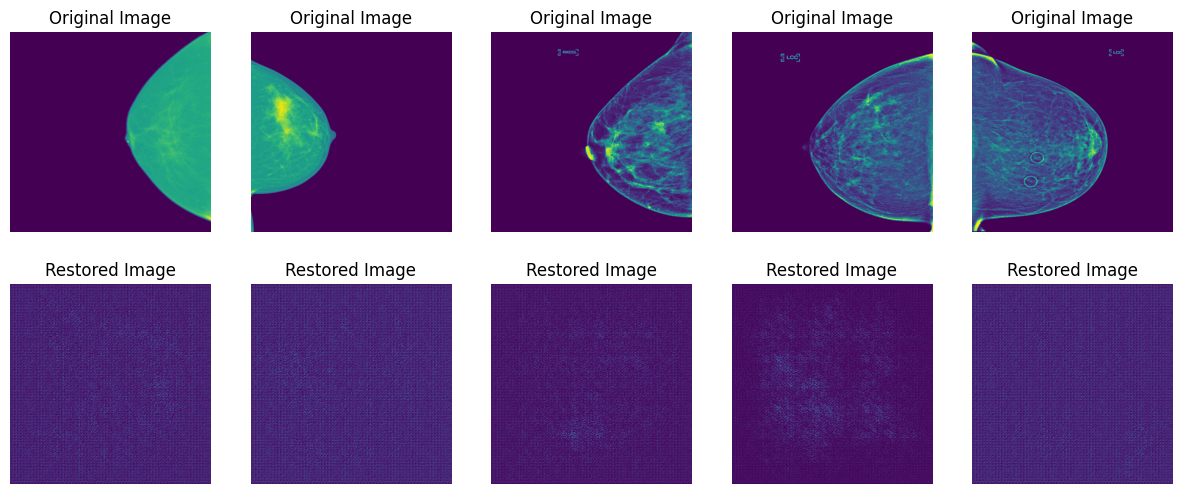

In [106]:
def visualize_images(original, restored, num_pairs=5):
    fig, axes = plt.subplots(2, num_pairs, figsize=(15, 6))

    for i in range(num_pairs):
        axes[0, i].set_title("Original Image")
        axes[0, i].axis('off')
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu())

        axes[1, i].set_title("Restored Image")
        axes[1, i].axis('off')
        axes[1, i].imshow(restored[i].permute(1, 2, 0).cpu())

    plt.show()


num_image_pairs_to_visualize = 5
with torch.no_grad():
    inputs, *_ = next(iter(val_dataloader))
    outputs = ae(inputs[: num_image_pairs_to_visualize])
    restored_images = outputs

visualize_images(inputs, restored_images, num_pairs=num_image_pairs_to_visualize)